### All Data: Consensus Genotype

* Size Ranges
* Training Dataset size : 100

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
import graphviz
import io
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


***
Training Set

Count : 100
*** 

In [2]:
# Import Training Data
df_train = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/5k_testSet/train/DEL/del_samp_100_train.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/5k_testSet/train/DEL/del_samp_100_train.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,GTconflict,GTcons,GTsupp,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,sample,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,type
0,-1,1,4,1.0,978.666667,22.947836,21.0,454.142857,82.867815,21.0,...,15.0,0,0,HG002,0,0.0,12851181,1,0.087879,Deletion


In [3]:
train_set = pd.DataFrame()
train_set = df_train_2

In [4]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

** Count of Labels in Training Set **

<a id='imbalance'></a>

In [5]:
pd.value_counts(train_set['GTcons'].values, sort=False)

Homozygous_Reference    20
Homozygous_Variant      29
Heterozygous_Variant    51
dtype: int64

***
Test Set

Count : 3504
***

<a id='hom_ref'></a>

In [7]:
# Import Test Data
df_test = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/5k_testSet/test/5k.DEL.test.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/5k_testSet/test/5k.DEL.test.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.shape

(3504, 187)

In [8]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'New_ID'}

In [9]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Ill300x.GT'], axis=1, inplace = True)
df_train.drop(['Ill250.GT'], axis=1, inplace = True)
df_train.drop(['IllMP.GT'], axis=1, inplace = True)
df_train.drop(['TenX.GT'], axis=1, inplace = True)
df_train.drop(['pacbio.GT'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [10]:
df_train.head(1)

,GTcons,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,1,978.666667,22.947836,21.0,454.142857,82.867815,21.0,0.0,0.0,899.137056,...,11414.33333,3643.861517,15.0,0,0,0,0.0,12851181,1,0.087879


In [11]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [12]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTsupp',
 'Ill250.GT',
 'Ill300x.GT',
 'IllMP.GT',
 'New_ID',
 'SVtype',
 'TenX.GT',
 'id',
 'pacbio.GT',
 'sample',
 'type'}

In [13]:
### Drop columns that are not shared by both dataframes
df_test.drop(['Ill300x.GT'], axis=1, inplace = True)
df_test.drop(['Ill250.GT'], axis=1, inplace = True)
df_test.drop(['IllMP.GT'], axis=1, inplace = True)
df_test.drop(['TenX.GT'], axis=1, inplace = True)
df_test.drop(['pacbio.GT'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)
df_test.drop(['New_ID'], axis=1, inplace = True)

***
Import '-1' Labeled Data (Unknown Data) 
*** 

In [14]:
# Import Test Data
# SVanalyzer generated training data
df_min1 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/min1_DFs/DEL/del_HG002_min1.csv')
df_min1_2 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/dataframes/Step1_CombinedDFs/min1_DFs/DEL/del_HG002_min1.csv')
df_min1.rename(columns={'size': 'Size'}, inplace=True)
df_min1.drop(['New_ID'], axis=1, inplace = True)
df_min1.drop(['index'], axis=1, inplace = True)
df_min1.shape

(1241, 188)

In [15]:
df_min1['chrom'].replace('X', 23, inplace=True)
df_min1['chrom'].replace('Y', 24, inplace=True)

In [16]:
### Drop columns that are not shared by both dataframes
df_min1.drop(['Ill300x.GT'], axis=1, inplace = True)
df_min1.drop(['Ill250.GT'], axis=1, inplace = True)
df_min1.drop(['IllMP.GT'], axis=1, inplace = True)
df_min1.drop(['TenX.GT'], axis=1, inplace = True)
df_min1.drop(['pacbio.GT'], axis=1, inplace = True)
df_min1.drop(['GTconflict'], axis=1, inplace = True)
df_min1.drop(['GTsupp'], axis=1, inplace = True)
df_min1.drop(['sample'], axis=1, inplace = True)
df_min1.drop(['SVtype'], axis=1, inplace = True)
df_min1.drop(['type'], axis=1, inplace = True)
df_min1.drop(['id'], axis=1, inplace = True)

In [17]:
c = list(df_train.columns.values)
d = list(df_min1.columns.values)
print (set(d) - set(c))

{'TenX.HP2_amb_reason_alignmentScore_insertSizeScore', 'TenX.HP1_amb_reason_alignmentScore_insertSizeScore'}


In [18]:
print (set(c) - set(d))

set()


***
Impute missing values using KNN
***

In [19]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,GTcons,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,1,978.666667,22.947836,21.0,454.142857,82.867815,21.0,0.0,0.0,899.137056,...,11414.33333,3643.861517,15.0,0,0,0,0.0,12851181,1,0.087879
1,2,952.851064,21.883617,47.0,422.936170,87.731312,47.0,0.0,0.0,861.723077,...,0.00000,0.000000,0.0,0,0,0,0.0,107997214,1,1.000000
2,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,881.435345,...,11012.00000,3244.344244,33.0,0,0,0,0.0,7428579,1,0.123494


In [20]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/100 with 0 missing, elapsed time: 0.012


In [21]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,GTcons,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,1.0,978.666667,22.947836,21.0,454.142857,82.867815,21.0,0.0,0.0,899.137056,...,11414.33333,3643.861517,15.0,0.0,0.0,0.0,0.0,12851181.0,1.0,0.087879
1,2.0,952.851064,21.883617,47.0,422.936170,87.731312,47.0,0.0,0.0,861.723077,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,107997214.0,1.0,1.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,881.435345,...,11012.00000,3244.344244,33.0,0.0,0.0,0.0,0.0,7428579.0,1.0,0.123494


In [22]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['GTcons']

In [23]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

1.0    51
2.0    29
0.0    20
dtype: int64

In [24]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [25]:
# Remove labels from feature set
X.drop(['GTcons'],axis=1, inplace = True)

In [26]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

** Train Random Forest Classifier **

<a id='multi_run'></a>

** Determine Number of trees: Out of Bag Error **

In [27]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3)

In [28]:
# Train Random Forest Classifier
model = RandomForestClassifier(oob_score=True) 
model.fit(X_train, y_train)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [29]:
print('The OOB prediction of accuracy is: {oob}%'.format(oob=model.oob_score_ * 100))

The OOB prediction of accuracy is: 87.14285714285714%


In [30]:
sns.set_style("white")

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/ensemble/forest.py

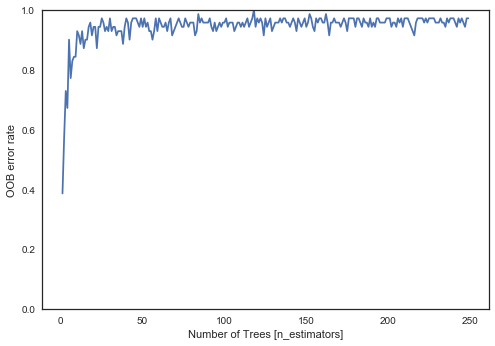

In [31]:
n_estimators = 250
trees = []
oob = []
for i in range(1, n_estimators):
    model.set_params(n_estimators=i)
    model.fit(X_train, y_train)
    trees += [i]
    oob += [model.oob_score_] 
    
    
df_oob = pd.DataFrame()
df_oob['trees'] = trees
df_oob['oob'] = oob


plt.plot(trees, oob)

plt.xlabel("Number of Trees [n_estimators]")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.ylim(0, 1.0)
plt.savefig('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/del_alldata_100_trees_oob_100.png', bbox_inches='tight')
plt.show()

** Train Model Using Optimal Tuning Parameters**

In [32]:
model = RandomForestClassifier(n_estimators=50, random_state=4, class_weight="balanced") 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=4,
            verbose=0, warm_start=False)

In [33]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



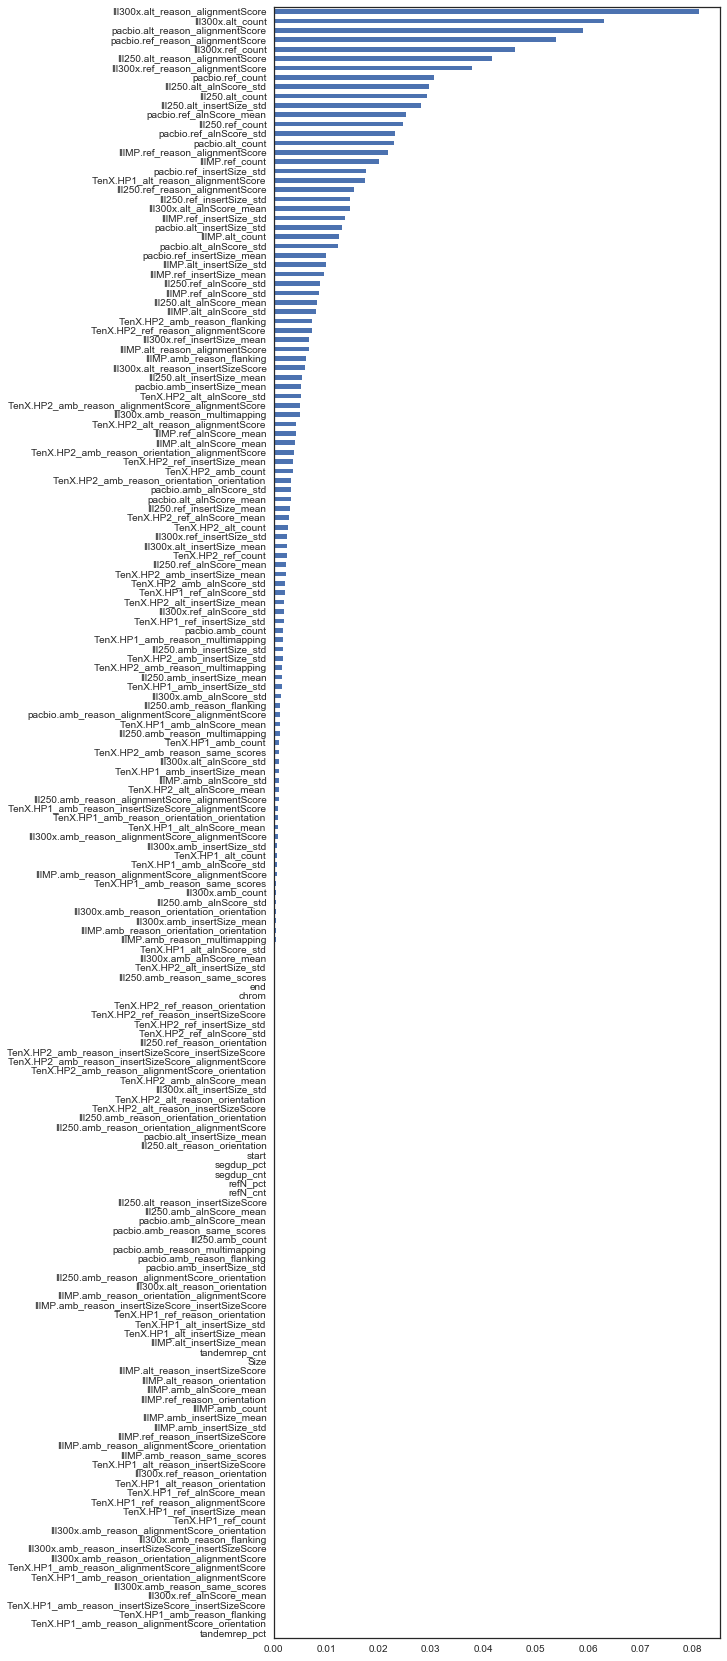

In [34]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(8,30))
plt.savefig('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/del_alldata_100_featImp_100.png', bbox_inches='tight')
plt.show()


In [36]:
feature_importances.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/del_alldata_100_featImp_100.csv')

In [37]:
X_ = X4[['Ill300x.alt_reason_alignmentScore','Ill300x.alt_count','pacbio.alt_reason_alignmentScore','pacbio.ref_reason_alignmentScore','Ill300x.ref_count','Ill250.alt_reason_alignmentScore','Ill300x.ref_reason_alignmentScore','pacbio.ref_count','Ill250.alt_alnScore_std','Ill250.alt_count','Ill250.alt_insertSize_std','pacbio.ref_alnScore_mean','Ill250.ref_count','pacbio.ref_alnScore_std','pacbio.alt_count','IllMP.ref_reason_alignmentScore','IllMP.ref_count','pacbio.ref_insertSize_std','TenX.HP1_alt_reason_alignmentScore','Ill250.ref_reason_alignmentScore','Ill250.ref_insertSize_std','Ill300x.alt_alnScore_mean','IllMP.ref_insertSize_std','pacbio.alt_insertSize_std','IllMP.alt_count']]

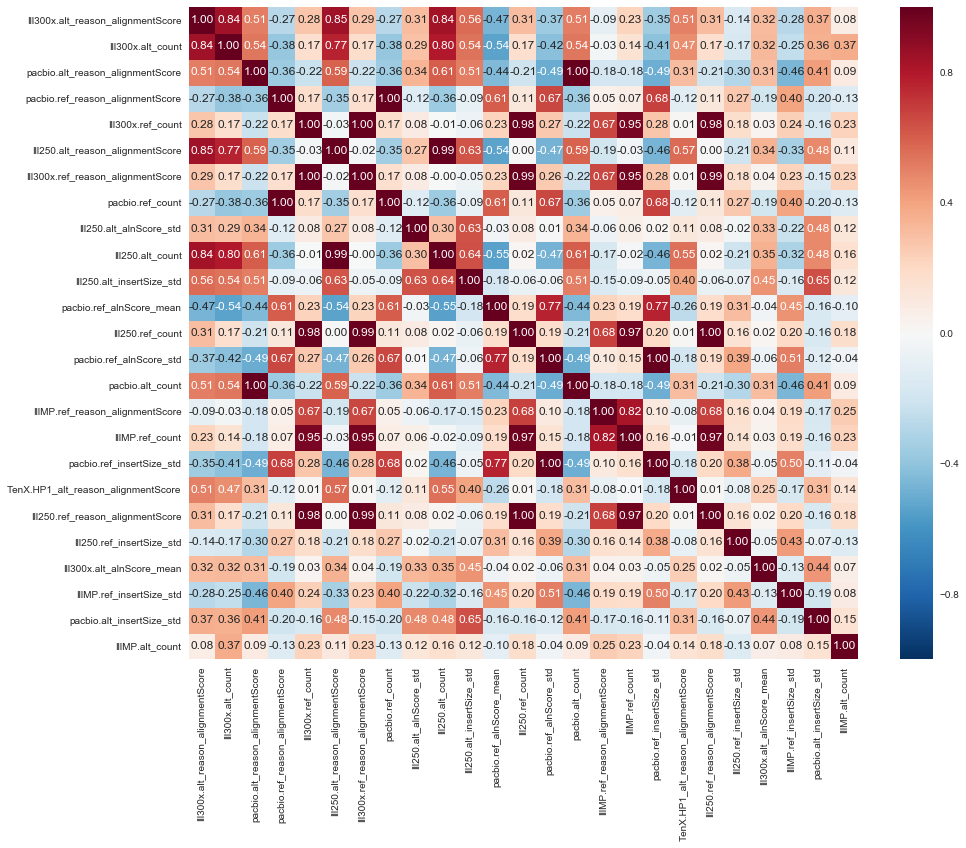

In [38]:
plt.figure(figsize=(15, 12))
sns.heatmap(X_.corr(), annot=True, fmt=".2f")
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.savefig('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/del_alldata_100__heatmap_100.png', bbox_inches='tight')
plt.show()

In [39]:
pred = model.predict(X_test)

In [40]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(y_test, pred, average='micro'))) 
from sklearn.metrics import accuracy_score
print('Accuracy score of the training subset: {:.3f}'.format(accuracy_score(y_test, pred))) 

Precision score of the training subset: 0.967
Accuracy score of the training subset: 0.967


In [41]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
labels = pd.DataFrame(y_test)

In [42]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']

In [43]:
df_Xtest['GTcons'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTcons'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTcons'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [44]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

Heterozygous_Variant    17
Homozygous_Reference     5
Homozygous_Variant       8
dtype: int64

In [45]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Heterozygous_Variant    17
Homozygous_Reference     6
Homozygous_Variant       7
dtype: int64

In [46]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[17  0  0]
 [ 0  5  0]
 [ 0  1  7]]


In [47]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,17,0,0,17
Homozygous_Reference,0,5,0,5
Homozygous_Variant,0,1,7,8
All,17,6,7,30


In [48]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       1.00      1.00      1.00        17
Homozygous_Reference       0.83      1.00      0.91         5
  Homozygous_Variant       1.00      0.88      0.93         8

         avg / total       0.97      0.97      0.97        30



***
Predict

Predict labels for test set
***

** Load Data **

In [49]:
df_test.drop(['GTcons'],axis=1, inplace=True)
X2 = df_test

** Impute missing values using KNN **

In [50]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/3504 with 0 missing, elapsed time: 10.192
Imputing row 101/3504 with 0 missing, elapsed time: 10.210
Imputing row 201/3504 with 0 missing, elapsed time: 10.218
Imputing row 301/3504 with 0 missing, elapsed time: 10.233
Imputing row 401/3504 with 1 missing, elapsed time: 10.246
Imputing row 501/3504 with 0 missing, elapsed time: 10.253
Imputing row 601/3504 with 0 missing, elapsed time: 10.269
Imputing row 701/3504 with 0 missing, elapsed time: 10.284
Imputing row 801/3504 with 59 missing, elapsed time: 10.290
Imputing row 901/3504 with 0 missing, elapsed time: 10.301
Imputing row 1001/3504 with 1 missing, elapsed time: 10.308
Imputing row 1101/3504 with 3 missing, elapsed time: 10.324
Imputing row 1201/3504 with 1 missing, elapsed time: 10.335
Imputing row 1301/3504 with 0 missing, elapsed time: 10.345
Imputing row 1401/3504 with 1 missing, elapsed time: 10.368
Imputing row 1501/3504 with 0 missing, elapsed time: 10.385
Imputing row 1601/3504 with 3 missing, elapsed time

In [51]:
df_test_header = list(df_test.columns.values)
X2.columns = df_test_header
X2.head(3)

,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,Ill250.amb_alnScore_std,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,980.534884,24.312260,43.0,444.790698,85.191046,42.0,1.0,0.0,863.292398,160.008066,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,95498964.0,1.0,0.117089
1,982.200000,12.175385,25.0,419.560000,60.020716,25.0,0.0,0.0,850.880000,170.692781,...,8671.60,3889.530045,15.0,0.0,0.0,1.0,1.0,14399929.0,1.0,1.000000
2,983.179487,5.750682,39.0,397.512820,75.999957,39.0,0.0,0.0,907.336634,141.925150,...,10437.35,3673.796705,20.0,0.0,0.0,0.0,0.0,76766532.0,0.0,0.000000


In [52]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,Ill250.amb_alnScore_std,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,980.534884,24.312260,43.0,444.790698,85.191046,42.0,1.0,0.0,863.292398,160.008066,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,95498964.0,1.0,0.117089
1,982.200000,12.175385,25.0,419.560000,60.020716,25.0,0.0,0.0,850.880000,170.692781,...,8671.60,3889.530045,15.0,0.0,0.0,1.0,1.0,14399929.0,1.0,1.000000
2,983.179487,5.750682,39.0,397.512820,75.999957,39.0,0.0,0.0,907.336634,141.925150,...,10437.35,3673.796705,20.0,0.0,0.0,0.0,0.0,76766532.0,0.0,0.000000


In [53]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [54]:
pred = model.predict(X5)
pred_prob = model.predict_proba(X5)
pred_prob_log = model.predict_log_proba(X5)

In [55]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['GTcons'] = df_test_2['GTcons']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTsupp'] = df_test_2['GTsupp']

In [56]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])
X6.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_df1_100.csv', index=False)

In [57]:
X6 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_df1_100.csv')

In [58]:
X6.rename(columns={'1': 'Homozygous_Reference_GTcons'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'predicted_label': 'predicted_GTcons_label'}, inplace=True)

In [59]:
X6.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_df2_100.csv')

In [60]:
X6['GTcons'].dtypes

dtype('int64')

In [61]:
# Drop NaN Labels
X6 = X6[np.isfinite(X6['GTcons'])]
X6 = X6[np.isfinite(X6['predicted_GTcons_label'])]

***
Label Analysis
***

In [62]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['predicted_GTcons_label']
print(confusion_matrix(consensus_GT, predict))

[[ 887   34    0]
 [  10 1850   52]
 [   5   49  617]]


In [63]:
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['predicted_GTcons_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [64]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 
print('Accuracy score of the prediction subset: {:.3f}'.format(accuracy_score(consensus_GT, predict))) 

Precision score of the prediction subset: 0.957
Accuracy score of the prediction subset: 0.957


In [65]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1850,10,52,1912
Homozygous_Reference,34,887,0,921
Homozygous_Variant,49,5,617,671
All,1933,902,669,3504


In [66]:
conf_mat = pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)
conf_mat.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/100_confMatrix_100.csv')

** Labels with Pred_Prob >=0.9 **

In [67]:
high_conf_labels = X6[(X6['Homozygous_Reference_GTcons'] == 1) | (X6['Homozygous_Reference_GTcons'] >= 0.9) | (X6['Heterozygous_Variant_GTcons'] == 1) | (X6['Heterozygous_Variant_GTcons'] >= 0.9) | (X6['Homozygous_Variant_GTcons'] == 1) | (X6['Homozygous_Variant_GTcons'] >= 0.9)]

In [68]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['predicted_GTcons_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1273,0,0,1273
Homozygous_Reference,0,550,0,550
Homozygous_Variant,0,0,197,197
All,1273,550,197,2020


In [69]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['predicted_GTcons_label']
conf_mat = pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)
conf_mat.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/100_confMatrix_hi_100.csv')

In [70]:
print(classification_report(consensus_GT, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       1.00      1.00      1.00      1273
Homozygous_Reference       1.00      1.00      1.00       550
  Homozygous_Variant       1.00      1.00      1.00       197

         avg / total       1.00      1.00      1.00      2020



***
Predict

Predict labels for minus 1 (unknown label) set
***

<font color='#10A0F9'>Try this step when the optimal training count is selected. You will have to drop 2 columns : 'TenX.HP1_amb_reason_insertSizeScore_alignmentScore', 'TenX.HP2_amb_reason_insertSizeScore_alignmentScore' from the 'train' dataframe</font> 

** Load Data **

In [ ]:
df_min1.drop(['GTcons'],axis=1, inplace=True)
X2 = df_min1

** Impute missing values using KNN **

In [ ]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

In [ ]:
df_min1_header = list(df_min1.columns.values)
X2.columns = df_min1_header
X2.head(3)

In [ ]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

In [ ]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [ ]:
pred = model.predict(X5)
pred_prob = model.predict_proba(X5)
pred_prob_log = model.predict_log_proba(X5)

In [ ]:
X5['predicted_label'] = pred
X5['chrom'] = df_min1_2['chrom']
X5['GTcons'] = df_min1_2['GTcons']
X5['start'] = df_min1_2['start']
X5['end'] = df_min1_2['end']
X5['Size'] = df_min1_2['Size']
X5['GTsupp'] = df_min1_2['GTsupp']

In [ ]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])
X6.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_min1_df1_100.csv', index=False)

In [ ]:
X6 = pd.read_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_min1_df1_100.csv')

In [ ]:
X6.rename(columns={'1': 'Homozygous_Reference_GTcons'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'predicted_label': 'predicted_GTcons_label'}, inplace=True)

In [ ]:
X6.to_csv('/Volumes/lesleydata/size_sample/Step4_ML/plots/DEL/all_data/5k_Test_Set/100_train/dataframes/df_alldata_100_min1_df2_100.csv')